In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isdir, isfile, join
from scipy.optimize import curve_fit

In [2]:
"""Load data"""
def load_data(path = './results'):
    lines = open(f'{path}/data.txt', 'r').readlines()
    lines.pop(-1)
    
    data = {
        'wt_name' : [str(line.split('\t')[0]) for line in lines],
        'wt_length' : np.array([int(line.split('\t')[1]) for line in lines]),
        'contacts' : np.array([int(line.split('\t')[2]) for line in lines]),
        'distance_threshold' : np.unique([float(line.split('\t')[3]) for line in lines]),
        'ex_eff_energy' : np.array([float(line.split('\t')[4]) for line in lines]),
        'ex_dt' : np.array([float(line.split('\t')[5]) for line in lines]),
        'im_eff_energy' : np.array([float(line.split('\t')[6]) for line in lines]),
        'im_dt' : np.array([float(line.split('\t')[7]) for line in lines]),
        'plddt' : np.array([float(line.split('\t')[8]) for line in lines])
    }
    return data

In [3]:
# Load funcs
data = load_data()

In [4]:
# Check for plots directory
plots_dir = './plots'
onlydirs = [f'./{d}' for d in listdir('./') if isdir(f'./{d}')]
if (plots_dir in onlydirs) == False: os.mkdir(f'./{plots_dir}')

Effective energy means and standard deviations for the two methods:
explicit method : 0.12186 ± 0.06300 
implicit method : 0.21126 ± 0.07006  

Time spent means and standard deviations for the two methods:
explicit method : 20.49252 ± 24.77598 s
implicit method : 6.29316 ± 7.19318 s 



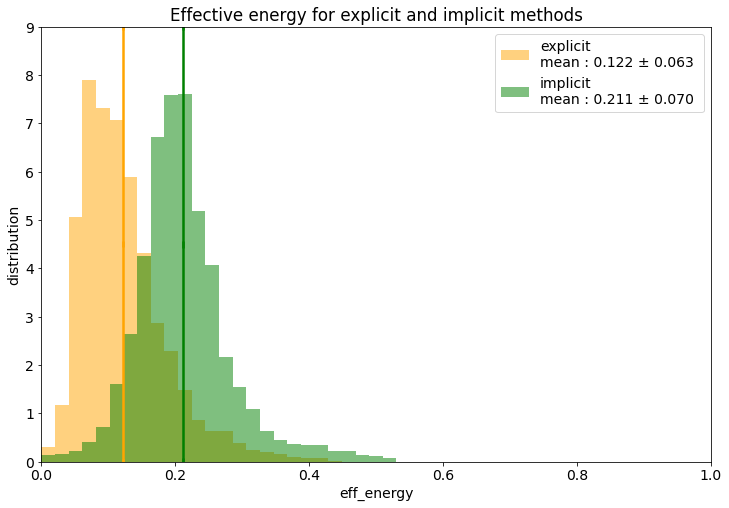

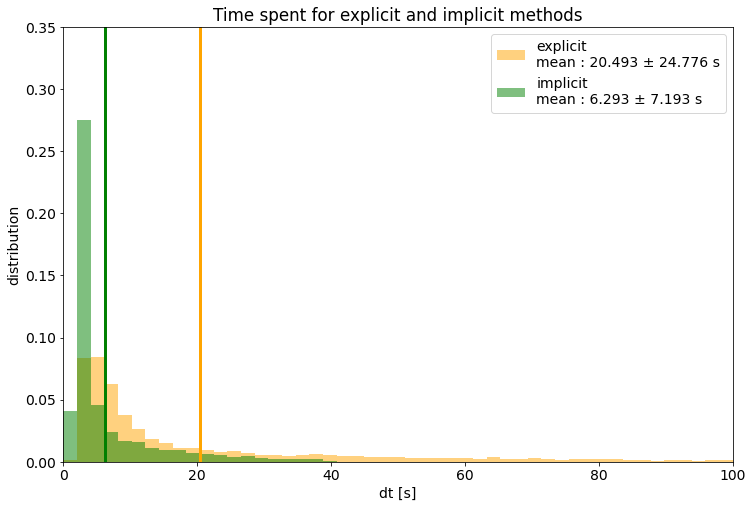

In [5]:
# Histograms
keys = ['eff_energy', 'dt']
titles = ['Effective energy', 'Time spent']
xlims = [[0., 1.], [0., 100.]]
ylims = [[0., 9.], [0., 0.35]]
units = ['', 's']

plt.rcParams.update({'font.size': 14})
for idx, (key, title, xlim, ylim, unit) in enumerate(zip(keys, titles, xlims, ylims, units)):
    fig = plt.figure(figsize = (12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.set_title(f'{title} for explicit and implicit methods')
    bins = np.linspace(xlim[0], xlim[1], 50)

    ex_mean = data[f'ex_{key}'].mean()
    ex_std = data[f'ex_{key}'].std()
    ax.hist(data[f'ex_{key}'], bins, density = True, alpha = 0.5, color = 'orange', 
            label = f'explicit\nmean : {format(ex_mean, ".3f")} ± {format(ex_std, ".3f")} {unit}')
    ax.errorbar([ex_mean] * 3, [0., 4.5, 9.], yerr = [ex_std] * 3, color = 'orange', linewidth = 2.5)

    im_mean = data[f'im_{key}'].mean()
    im_std = data[f'im_{key}'].std()
    ax.hist(data[f'im_{key}'], bins, density = True, alpha = 0.5, color = 'green', 
            label = f'implicit\nmean : {format(im_mean, ".3f")} ± {format(im_std, ".3f")} {unit}')
    ax.errorbar([im_mean] * 3, [0., 4.5, 9.], yerr = [im_std] * 3, color = 'green', linewidth = 2.5)

    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('distribution')
    if idx == 0: ax.set_xlabel(f'{key}')
    else: ax.set_xlabel(f'{key} [{unit}]')
    ax.legend()

    plt.savefig(f'{plots_dir}/{key}_hist.png', bbox_inches='tight')
    
    print(f'{title} means and standard deviations for the two methods:')
    print(f'explicit method : {format(ex_mean, ".5f")} ± {format(ex_std, ".5f")} {unit}')
    print(f'implicit method : {format(im_mean, ".5f")} ± {format(im_std, ".5f")} {unit}', '\n')

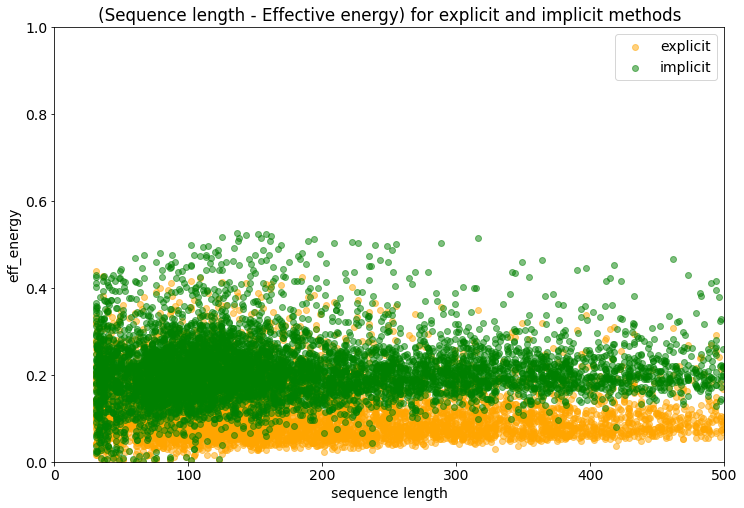

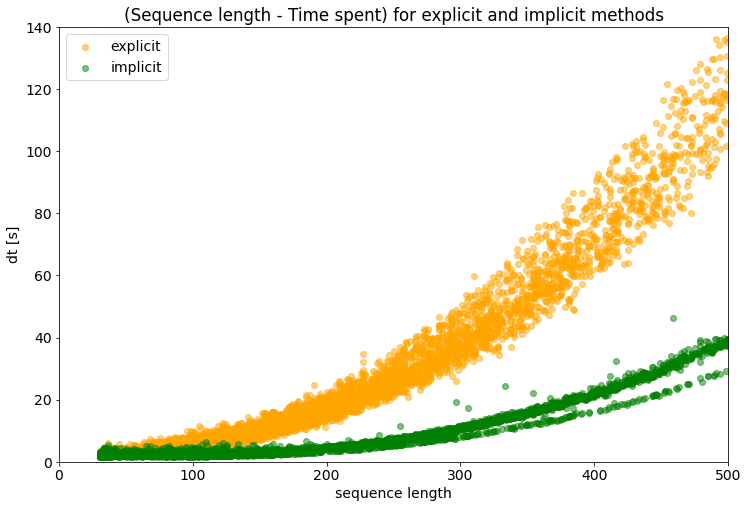

In [6]:
#Scatterplots
keys = ['eff_energy', 'dt']
titles = ['Effective energy', 'Time spent']
ylims = [[0., 1.], [0., 140.]]
units = ['', 's']

for idx, (key, title, ylim, unit) in enumerate(zip(keys, titles, ylims, units)):
    fig = plt.figure(figsize = (12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.set_title(f'(Sequence length - {title}) for explicit and implicit methods')
    ax.scatter(data[f'wt_length'], data[f'ex_{key}'], color = 'orange', alpha = 0.5, label = 'explicit')
    ax.scatter(data[f'wt_length'], data[f'im_{key}'], color = 'green', alpha = 0.5, label = 'implicit')
    
    ax.set_xlim([0., 500.])
    ax.set_ylim(ylim)
    ax.set_xlabel('sequence length')
    if idx == 0: ax.set_ylabel(f'{key}')
    else: ax.set_ylabel(f'{key} [{unit}]')
    ax.legend()

    plt.savefig(f'{plots_dir}/{key}_scatt.png', bbox_inches='tight');

In [31]:
#data['wt_length'].min() = 31
bins = np.linspace(30, 500, 48)
binned_means = np.zeros(len(bins) - 1)
for iedge in range(len(bins[:-1])):
    mask = (data['wt_length'] > bins[iedge]).astype(int) * (data['wt_length'] < bins[iedge + 1]).astype(int)
    binned_means[iedge] = np.mean(data['ex_eff_energy'][mask])

arith_mean = np.mean(data['ex_eff_energy'])
weighted_mean = np.mean(binned_means)

print('Explicit effective energy means:')
print(f'- arithmetic: {format(arith_mean, ".5f")}')
print(f'- weighted:   {format(weighted_mean, ".5f")}')

Explicit effective energy means:
- arithmetic: 0.12186
- weighted:   0.12656


dt fit (as a function of the sequence length) for the two methods:
explicit method : k = 0.00010137, lamda = 2.24430, y0 = 2.52191
implicit method : k = 0.00000052, lamda = 2.90848, y0 = 2.06703
where the fitted function is: f(x) = kx^lamda + y0 



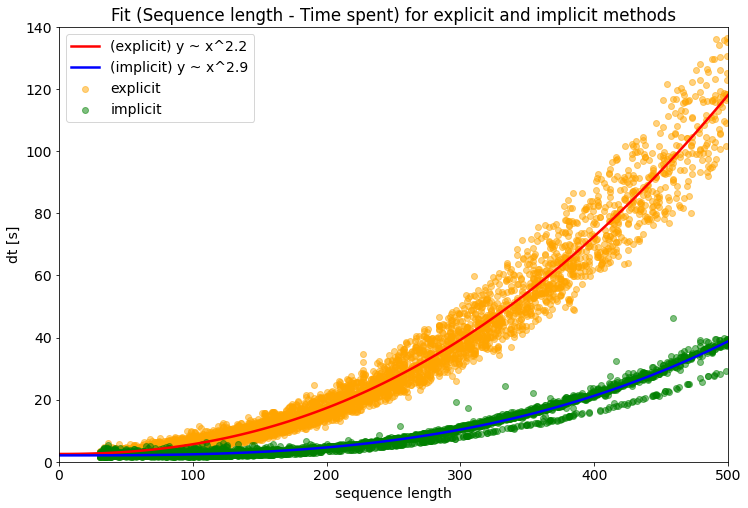

In [7]:
# Time fit
def power_func(x, k, lamda, y0):
    return k * x ** lamda + y0

x = data['wt_length']
ex_y = data['ex_dt']
im_y = data['im_dt']
ex_popt, _ = curve_fit(power_func, x, ex_y, p0 = [0., 2., 5.])
im_popt, _ = curve_fit(power_func, x, im_y, p0 = [0., 2., 5.])

xplot = np.linspace(0, 500, 100)
ex_yplot = power_func(xplot, ex_popt[0], ex_popt[1], ex_popt[2])
im_yplot = power_func(xplot, im_popt[0], im_popt[1], im_popt[2])

print(f'dt fit (as a function of the sequence length) for the two methods:')
print(f'explicit method : k = {format(ex_popt[0], ".8f")}, lamda = {format(ex_popt[1], ".5f")}, y0 = {format(ex_popt[2], ".5f")}')
print(f'implicit method : k = {format(im_popt[0], ".8f")}, lamda = {format(im_popt[1], ".5f")}, y0 = {format(im_popt[2], ".5f")}')
print(r'where the fitted function is: f(x) = kx^lamda + y0', '\n')

fig = plt.figure(figsize = (12, 8))
ax = plt.subplot(1, 1, 1)
ax.set_title(f'Fit (Sequence length - Time spent) for explicit and implicit methods')
ax.scatter(data[f'wt_length'], data[f'ex_dt'], color = 'orange', alpha = 0.5, label = 'explicit')
ax.plot(xplot, ex_yplot, color = 'red', linewidth = 2.5, label = f'(explicit) y ~ x^{format(ex_popt[1], ".1f")}')

ax.scatter(data[f'wt_length'], data[f'im_dt'], color = 'green', alpha = 0.5, label = 'implicit')
ax.plot(xplot, im_yplot, color = 'blue', linewidth = 2.5, label = f'(implicit) y ~ x^{format(im_popt[1], ".1f")}')
    
ax.set_xlim([0., 500.])
ax.set_ylim([0., 140.])
ax.set_xlabel('sequence length')
ax.set_ylabel('dt [s]')
ax.legend()

plt.savefig(f'{plots_dir}/dt_fit.png', bbox_inches='tight');

Contact number fit (as a function of the sequence length):
m = 4.3, c = -75.0
where the fitted function is: f(x) = mx + c 



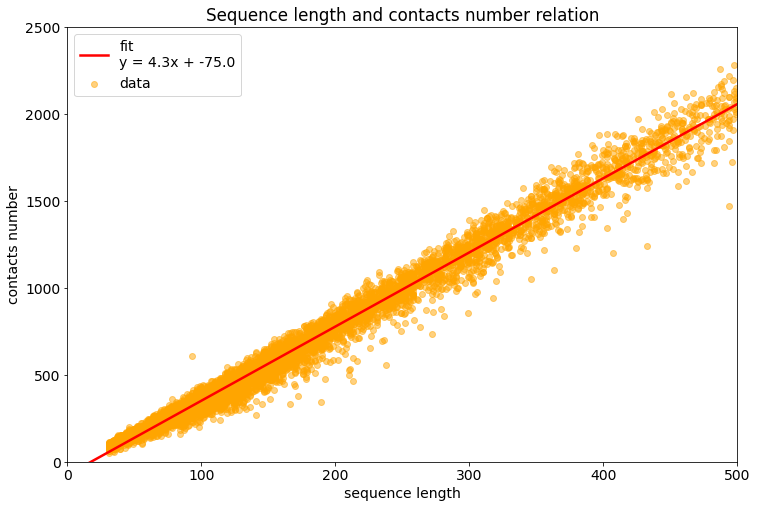

In [8]:
# Contact number fit
def rect_func(x, m, c):
    return m * x + c

x = data['wt_length']
y = data['contacts']
popt, _ = curve_fit(rect_func, x, y, p0 = [2.5, 0])

xplot = np.linspace(0, 500, 100)
yplot = rect_func(xplot, popt[0], popt[1])

print(f'Contact number fit (as a function of the sequence length):')
print(f'm = {format(popt[0], ".1f")}, c = {format(popt[1], ".1f")}')
print(r'where the fitted function is: f(x) = mx + c', '\n')

fig = plt.figure(figsize = (12, 8))
ax = plt.subplot(1, 1, 1)
ax.set_title('Sequence length and contacts number relation')
ax.scatter(data['wt_length'], data['contacts'], color = 'orange', alpha = 0.5, label = 'data')
ax.plot(xplot, yplot, color = 'red', linewidth = 2.5, label = f'fit\ny = {format(popt[0], ".1f")}x + {format(popt[1], ".1f")}')

ax.set_xlim([0., 500.])
ax.set_ylim([0., 2500.])
ax.set_xlabel('sequence length')
ax.set_ylabel('contacts number')
ax.legend()

plt.savefig(f'{plots_dir}/contacts_fit.png', bbox_inches='tight');

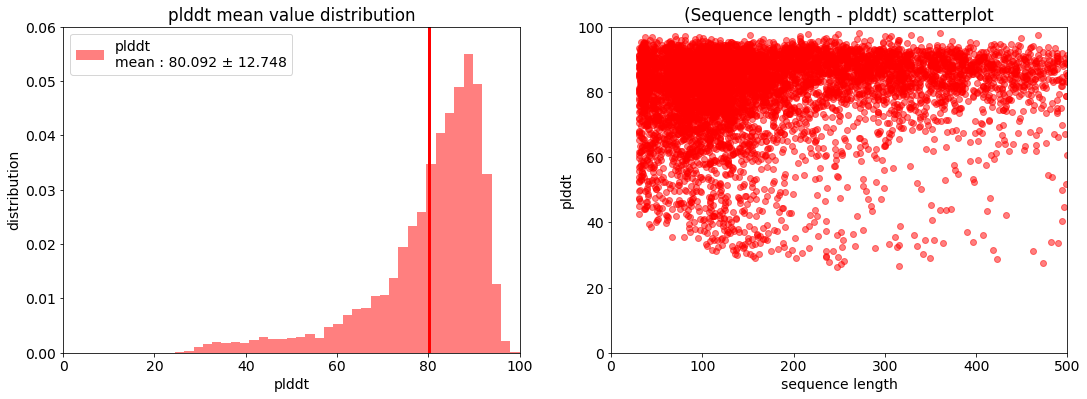

In [9]:
fig = plt.figure(figsize = (18, 6))

# plddt histogram
ax = plt.subplot(1, 2, 1)
ax.set_title('plddt mean value distribution')
bins = np.linspace(0, 100, 50)

mean = data['plddt'].mean()
std = data['plddt'].std()
ax.hist(data['plddt'], bins, density = True, alpha = 0.5, color = 'red',
        label = f'plddt\nmean : {format(mean, ".3f")} ± {format(std, ".3f")}')
ax.errorbar([mean] * 3, [0., 0.03, 0.06], yerr = [std] * 3, color = 'red', linewidth = 2.5)

ax.set_ylim([0., 0.06])
ax.set_xlim([0, 100])
ax.set_ylabel('distribution')
ax.set_xlabel('plddt')
ax.legend()

# plddt scatterplot
ax = plt.subplot(1, 2, 2)
ax.set_title('(Sequence length - plddt) scatterplot')
ax.scatter(data['wt_length'], data['plddt'], alpha = 0.5, color = 'red')
ax.set_ylim([0, 100])
ax.set_xlim([0, 500])
ax.set_ylabel('plddt')
ax.set_xlabel('sequence length')

plt.savefig(f'{plots_dir}/plddt.png', bbox_inches='tight');

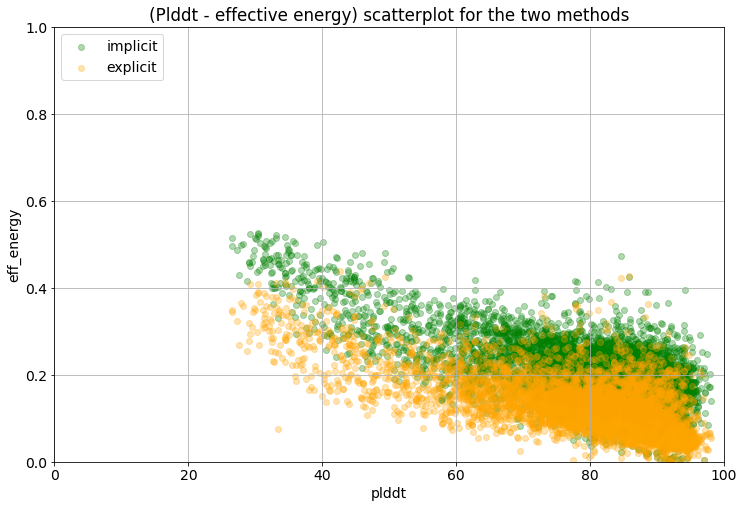

In [10]:
fig = plt.figure(figsize = (12, 8))

ax = plt.subplot(1, 1, 1)
ax.set_title('(Plddt - effective energy) scatterplot for the two methods')
ax.scatter(data['plddt'], data['im_eff_energy'], alpha = 0.3, color = 'green', label = 'implicit')
ax.scatter(data['plddt'], data['ex_eff_energy'], alpha = 0.3, color = 'orange', label = 'explicit')
ax.set_ylim([0., 1.])
ax.set_xlim([0, 100])
ax.set_ylabel('eff_energy')
ax.set_xlabel('plddt')
ax.grid(True)
ax.legend(loc = 'upper left')

plt.savefig(f'{plots_dir}/plddt_eff_energy_scatt.png', bbox_inches='tight');